# XGBoost model

In [12]:
import pandas as pd
import numpy as np
import os
import csv
from operator import itemgetter
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

import nDCG
import utils

## Load dataset and choose features

In [9]:
# load dataset
df = pd.read_pickle('cleaned_dataset')

# add column with relevance scores
df['relevance'] = df['booking_bool'] + df['click_bool']

# change relevance column with relevance score (1 if clicked, 5 if booked)
df['relevance'] = df['relevance'].map({0:0, 1:1, 2:5})

# select features to train model with
selected_features = ['site_id', 'visitor_location_country_id',
                       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
                       'prop_starrating', 'prop_review_score', 'prop_brand_bool',
                       'prop_location_score1', 'prop_location_score2',
                       'prop_log_historical_price', 'price_usd', 'promotion_flag',
                       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
                       'srch_adults_count', 'srch_children_count', 'srch_room_count',
                       'srch_saturday_night_bool', 'srch_query_affinity_score',
                       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
                       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
                       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
                       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
                       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
                       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
                       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
                       'comp7_rate_percent_diff', 'comp8_rate', 'comp8_inv',
                       'comp8_rate_percent_diff',  'price_diff_from_historic_mean',
                       'star_diff_from_historic_mean', 'price_rank', 'star_rank',
                       'value_for_money', 'price_usd_normalized']

# create new dataframe with predictive features
features_to_keep = ['relevance', 'srch_id', 'prop_id', 'booking_bool']
all_possible_features = selected_features + features_to_keep
df_select = df.loc[:,all_possible_features]

# drop NaNs (optional)
df_select=df_select.dropna()

## Divide dataset in train/validation/test

In [10]:
# create list of ids in random order
id_list = df.srch_id.unique()
np.random.shuffle(id_list)

# for reproducibility 
rand_seed = 3000
np.random.seed(rand_seed)

# training - test fraction is 80/20
id_train = int(len(id_list) * 0.8)
training_id = id_list[:id_train]
test_id = id_list[id_train:]

# divide dataset in test and training set
train_data = df_select.loc[df.srch_id.isin(training_id)]
test_data = df_select.loc[df.srch_id.isin(test_id)]

## Downsampling

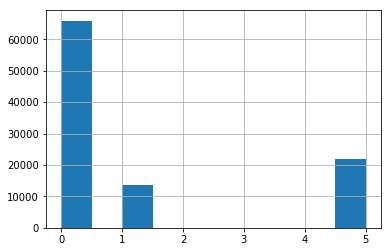

In [16]:
# choose whether to balance training data
balance_flag = True
downsampling_rate = 3
if balance_flag:
    train_data = utils.balance_dataset(train_data, downsampling_rate)

## What does this graph show?

## Training the model

In [21]:
# read in data
dtrain = xgb.DMatrix('train.txt')
dtest = xgb.DMatrix('test.txt')

# specify parameters via map
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)

# make prediction
preds = bst.predict(dtest)

In [22]:
preds

array([ 0.28583017,  0.92392391,  0.28583017, ...,  0.92392391,
        0.05169873,  0.92392391], dtype=float32)